In [1]:
import pybedtools as pbt
import pysam
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as ss
import seqlogo as sl
from collections import Counter

In [2]:
import splanl.post_processing as pp
import splanl.custom_splai_scores as css

Using TensorFlow backend.


In [3]:
mane_bd = pd.read_table( '/nfs/kitzman2/smithcat/refs/gencode/gencode.v38lift37.MANESelect.bed',
                         names = [ 'chrom', 'start', 'end', 'name', 'score', 'strand' ] )

In [4]:
mane_bd

,chrom,start,end,name,score,strand
0,chr1,65565,65573,ENSG00000186092.7_1,.,+
1,chr1,69037,70005,ENSG00000186092.7_1,.,+
2,chr1,859812,860328,ENSG00000187634.13_1,.,+
3,chr1,861302,861393,ENSG00000187634.13_1,.,+
4,chr1,865535,865716,ENSG00000187634.13_1,.,+
...,...,...,...,...,...,...
176469,chrY,59230782,59230919,ENSG00000124333.16_1_PAR_Y,.,+
176470,chrY,59233167,59233257,ENSG00000124333.16_1_PAR_Y,.,+
176471,chrY,59252483,59252550,ENSG00000124333.16_1_PAR_Y,.,+
176472,chrY,59272371,59272463,ENSG00000124333.16_1_PAR_Y,.,+


In [5]:
#this removes the last exon in each entry - don't want 3' UTR
#should I do more to remove non-coding exons?
mane_bd_filt = mane_bd.loc[ mane_bd.groupby( 'name' ).cumcount( ascending= False ) > 0 ].copy()

In [6]:
mane_gtf = pd.read_table( '/nfs/kitzman2/smithcat/refs/gencode/gencode.v38lift37.MANESelect.gtf.gz',
                               compression = 'gzip',
                                sep = '\t',
                               comment = '#',
                               index_col = False,
                               names = [ 'chrom', 'source', 'feature', 'start', 'end', 'score', 'strand', 'frame', 'attribute' ] )
                                #dtype = { 'CHROM': object } )

In [7]:
mane_gtf[ 'gene_type' ] = [ a.split( ' ' )[ 1 ].replace( '"', '' ) 
                                 for att in mane_gtf.attribute 
                                 for a in att.split( '; ' )
                                 if a.split( ' ' )[ 0 ] == 'gene_type' ]

In [8]:
mane_gtf[ 'gene_id' ] = [ a.split( ' ' )[ 1 ].replace( '"', '' ) 
                                 for att in mane_gtf.attribute 
                                 for a in att.split( '; ' )
                                 if a.split( ' ' )[ 0 ] == 'gene_id' ]

In [9]:
mane_gtf.loc[ mane_gtf.feature != 'gene', 'transcript_id' ] = [ a.split( ' ' )[ 1 ].replace( '"', '' )
                                                                          for att in mane_gtf.attribute
                                                                          for a in att.split( '; ' )
                                                                          if a.split( ' ' )[ 0 ] == 'transcript_id'  ]

In [10]:
gene_to_trans = { gene: trans 
                  for trans,gene in zip( mane_gtf.loc[ mane_gtf.feature != 'gene' ].transcript_id,
                                         mane_gtf.loc[ mane_gtf.feature != 'gene' ].gene_id ) }

In [11]:
mane_gtf.loc[ mane_gtf.feature == 'gene', 'transcript_id' ] = mane_gtf.loc[ mane_gtf.feature == 'gene' ].gene_id.apply( lambda x: gene_to_trans[ x ] )

In [12]:
mane_gtf.loc[ mane_gtf.feature == 'exon', 'exon_id' ] = [ a.split( ' ' )[ 1 ].replace( '"', '' )
                                                                          for att in mane_gtf.loc[ mane_gtf.feature == 'exon' ].attribute
                                                                          for a in att.split( '; ' )
                                                                          if a.split( ' ' )[ 0 ] == 'exon_id'  ]

In [13]:
ex_counts = mane_gtf[ [ 'transcript_id', 'exon_id' ] ].groupby( 'transcript_id' ).nunique()

In [14]:
mult_exons = ex_counts.loc[ ( ex_counts.exon_id > 1 ) ].index.tolist()

In [15]:
mane_gtf_mult = mane_gtf.set_index( 'transcript_id' ).loc[ mult_exons ].reset_index().copy()

In [16]:
mane_gtf_mult

,transcript_id,chrom,source,feature,start,end,score,strand,frame,attribute,gene_type,gene_id,exon_id
0,ENST00000000233.10_1,chr7,HAVANA,gene,127228440,127231754,.,+,.,"gene_id ""ENSG00000004059.11_1""; gene_type ""pro...",protein_coding,ENSG00000004059.11_1,NaN
1,ENST00000000233.10_1,chr7,HAVANA,transcript,127228465,127231754,.,+,.,"gene_id ""ENSG00000004059.11_1""; transcript_id ...",protein_coding,ENSG00000004059.11_1,NaN
2,ENST00000000233.10_1,chr7,HAVANA,exon,127228465,127228619,.,+,.,"gene_id ""ENSG00000004059.11_1""; transcript_id ...",protein_coding,ENSG00000004059.11_1,ENSE00001872691.2_1
3,ENST00000000233.10_1,chr7,HAVANA,UTR,127228465,127228552,.,+,.,"gene_id ""ENSG00000004059.11_1""; transcript_id ...",protein_coding,ENSG00000004059.11_1,NaN
4,ENST00000000233.10_1,chr7,HAVANA,CDS,127228553,127228619,.,+,0,"gene_id ""ENSG00000004059.11_1""; transcript_id ...",protein_coding,ENSG00000004059.11_1,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...
469785,ENST00000684770.1_1,chr7,HAVANA,CDS,143421453,143421790,.,+,2,"gene_id ""ENSG00000170379.21_1""; transcript_id ...",protein_coding,ENSG00000170379.21_1,NaN
469786,ENST00000684770.1_1,chr7,HAVANA,exon,143424506,143427503,.,+,.,"gene_id ""ENSG00000170379.21_1""; transcript_id ...",protein_coding,ENSG00000170379.21_1,ENSE00003918454.1_1
469787,ENST00000684770.1_1,chr7,HAVANA,CDS,143424506,143424757,.,+,0,"gene_id ""ENSG00000170379.21_1""; transcript_id ...",protein_coding,ENSG00000170379.21_1,NaN
469788,ENST00000684770.1_1,chr7,HAVANA,UTR,143424758,143427503,.,+,.,"gene_id ""ENSG00000170379.21_1""; transcript_id ...",protein_coding,ENSG00000170379.21_1,NaN


In [17]:
mane_gtf_prot = mane_gtf_mult.loc[ mane_gtf_mult.gene_type == 'protein_coding' ].copy()

In [18]:
mane_gtf_prot

,transcript_id,chrom,source,feature,start,end,score,strand,frame,attribute,gene_type,gene_id,exon_id
0,ENST00000000233.10_1,chr7,HAVANA,gene,127228440,127231754,.,+,.,"gene_id ""ENSG00000004059.11_1""; gene_type ""pro...",protein_coding,ENSG00000004059.11_1,NaN
1,ENST00000000233.10_1,chr7,HAVANA,transcript,127228465,127231754,.,+,.,"gene_id ""ENSG00000004059.11_1""; transcript_id ...",protein_coding,ENSG00000004059.11_1,NaN
2,ENST00000000233.10_1,chr7,HAVANA,exon,127228465,127228619,.,+,.,"gene_id ""ENSG00000004059.11_1""; transcript_id ...",protein_coding,ENSG00000004059.11_1,ENSE00001872691.2_1
3,ENST00000000233.10_1,chr7,HAVANA,UTR,127228465,127228552,.,+,.,"gene_id ""ENSG00000004059.11_1""; transcript_id ...",protein_coding,ENSG00000004059.11_1,NaN
4,ENST00000000233.10_1,chr7,HAVANA,CDS,127228553,127228619,.,+,0,"gene_id ""ENSG00000004059.11_1""; transcript_id ...",protein_coding,ENSG00000004059.11_1,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...
469785,ENST00000684770.1_1,chr7,HAVANA,CDS,143421453,143421790,.,+,2,"gene_id ""ENSG00000170379.21_1""; transcript_id ...",protein_coding,ENSG00000170379.21_1,NaN
469786,ENST00000684770.1_1,chr7,HAVANA,exon,143424506,143427503,.,+,.,"gene_id ""ENSG00000170379.21_1""; transcript_id ...",protein_coding,ENSG00000170379.21_1,ENSE00003918454.1_1
469787,ENST00000684770.1_1,chr7,HAVANA,CDS,143424506,143424757,.,+,0,"gene_id ""ENSG00000170379.21_1""; transcript_id ...",protein_coding,ENSG00000170379.21_1,NaN
469788,ENST00000684770.1_1,chr7,HAVANA,UTR,143424758,143427503,.,+,.,"gene_id ""ENSG00000170379.21_1""; transcript_id ...",protein_coding,ENSG00000170379.21_1,NaN


In [19]:
mane_gtf_cds = mane_gtf_prot.loc[ mane_gtf_prot.feature == 'CDS' ].copy()

In [20]:
mane_gtf_cds

,transcript_id,chrom,source,feature,start,end,score,strand,frame,attribute,gene_type,gene_id,exon_id
4,ENST00000000233.10_1,chr7,HAVANA,CDS,127228553,127228619,.,+,0,"gene_id ""ENSG00000004059.11_1""; transcript_id ...",protein_coding,ENSG00000004059.11_1,NaN
7,ENST00000000233.10_1,chr7,HAVANA,CDS,127229137,127229217,.,+,2,"gene_id ""ENSG00000004059.11_1""; transcript_id ...",protein_coding,ENSG00000004059.11_1,NaN
9,ENST00000000233.10_1,chr7,HAVANA,CDS,127229539,127229648,.,+,2,"gene_id ""ENSG00000004059.11_1""; transcript_id ...",protein_coding,ENSG00000004059.11_1,NaN
11,ENST00000000233.10_1,chr7,HAVANA,CDS,127230120,127230191,.,+,0,"gene_id ""ENSG00000004059.11_1""; transcript_id ...",protein_coding,ENSG00000004059.11_1,NaN
13,ENST00000000233.10_1,chr7,HAVANA,CDS,127231017,127231142,.,+,0,"gene_id ""ENSG00000004059.11_1""; transcript_id ...",protein_coding,ENSG00000004059.11_1,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...
469779,ENST00000684770.1_1,chr7,HAVANA,CDS,143418374,143418471,.,+,2,"gene_id ""ENSG00000170379.21_1""; transcript_id ...",protein_coding,ENSG00000170379.21_1,NaN
469781,ENST00000684770.1_1,chr7,HAVANA,CDS,143419751,143419964,.,+,0,"gene_id ""ENSG00000170379.21_1""; transcript_id ...",protein_coding,ENSG00000170379.21_1,NaN
469783,ENST00000684770.1_1,chr7,HAVANA,CDS,143420304,143420543,.,+,2,"gene_id ""ENSG00000170379.21_1""; transcript_id ...",protein_coding,ENSG00000170379.21_1,NaN
469785,ENST00000684770.1_1,chr7,HAVANA,CDS,143421453,143421790,.,+,2,"gene_id ""ENSG00000170379.21_1""; transcript_id ...",protein_coding,ENSG00000170379.21_1,NaN


In [21]:
mane_gtf.loc[ mane_gtf.transcript_id == 'ENST00000000233.10_1' ]

,chrom,source,feature,start,end,score,strand,frame,attribute,gene_type,gene_id,transcript_id,exon_id
417152,chr7,HAVANA,gene,127228440,127231754,.,+,.,"gene_id ""ENSG00000004059.11_1""; gene_type ""pro...",protein_coding,ENSG00000004059.11_1,ENST00000000233.10_1,NaN
417153,chr7,HAVANA,transcript,127228465,127231754,.,+,.,"gene_id ""ENSG00000004059.11_1""; transcript_id ...",protein_coding,ENSG00000004059.11_1,ENST00000000233.10_1,NaN
417154,chr7,HAVANA,exon,127228465,127228619,.,+,.,"gene_id ""ENSG00000004059.11_1""; transcript_id ...",protein_coding,ENSG00000004059.11_1,ENST00000000233.10_1,ENSE00001872691.2_1
417155,chr7,HAVANA,UTR,127228465,127228552,.,+,.,"gene_id ""ENSG00000004059.11_1""; transcript_id ...",protein_coding,ENSG00000004059.11_1,ENST00000000233.10_1,NaN
417156,chr7,HAVANA,CDS,127228553,127228619,.,+,0,"gene_id ""ENSG00000004059.11_1""; transcript_id ...",protein_coding,ENSG00000004059.11_1,ENST00000000233.10_1,NaN
417157,chr7,HAVANA,start_codon,127228553,127228555,.,+,0,"gene_id ""ENSG00000004059.11_1""; transcript_id ...",protein_coding,ENSG00000004059.11_1,ENST00000000233.10_1,NaN
417158,chr7,HAVANA,exon,127229137,127229217,.,+,.,"gene_id ""ENSG00000004059.11_1""; transcript_id ...",protein_coding,ENSG00000004059.11_1,ENST00000000233.10_1,ENSE00003494180.1_1
417159,chr7,HAVANA,CDS,127229137,127229217,.,+,2,"gene_id ""ENSG00000004059.11_1""; transcript_id ...",protein_coding,ENSG00000004059.11_1,ENST00000000233.10_1,NaN
417160,chr7,HAVANA,exon,127229539,127229648,.,+,.,"gene_id ""ENSG00000004059.11_1""; transcript_id ...",protein_coding,ENSG00000004059.11_1,ENST00000000233.10_1,ENSE00003504066.1_1
417161,chr7,HAVANA,CDS,127229539,127229648,.,+,2,"gene_id ""ENSG00000004059.11_1""; transcript_id ...",protein_coding,ENSG00000004059.11_1,ENST00000000233.10_1,NaN


In [22]:
mane_gtf_plus = mane_gtf_cds.loc[ mane_gtf_cds.strand == '+' ].copy()

In [23]:
mane_gtf_neg = mane_gtf_cds.loc[ mane_gtf_cds.strand == '-' ].copy()

In [24]:
#this removes the last exon in each entry - don't want the last exon which doesn't splice
mane_gtf_plus_filt = mane_gtf_plus.loc[ mane_gtf_plus.sort_values( by = [ 'chrom', 'start' ] ).groupby( 'transcript_id' ).cumcount( ascending= False ) > 0 ].copy() 

In [25]:
#this removes the last exon in each entry - don't want the last exon which doesn't splice
mane_gtf_neg_filt = mane_gtf_neg.loc[ mane_gtf_neg.sort_values( by = [ 'chrom', 'start' ] ).groupby( 'transcript_id' ).cumcount( ascending= True ) > 0 ].copy() 

In [26]:
mane_gtf_neg_filt

,transcript_id,chrom,source,feature,start,end,score,strand,frame,attribute,gene_type,gene_id,exon_id
71,ENST00000001146.7_1,chr2,HAVANA,CDS,72360152,72360436,.,-,0,"gene_id ""ENSG00000003137.9_1""; transcript_id ""...",protein_coding,ENSG00000003137.9_1,NaN
73,ENST00000001146.7_1,chr2,HAVANA,CDS,72361890,72362045,.,-,0,"gene_id ""ENSG00000003137.9_1""; transcript_id ""...",protein_coding,ENSG00000003137.9_1,NaN
75,ENST00000001146.7_1,chr2,HAVANA,CDS,72362273,72362548,.,-,0,"gene_id ""ENSG00000003137.9_1""; transcript_id ""...",protein_coding,ENSG00000003137.9_1,NaN
77,ENST00000001146.7_1,chr2,HAVANA,CDS,72371118,72371342,.,-,0,"gene_id ""ENSG00000003137.9_1""; transcript_id ""...",protein_coding,ENSG00000003137.9_1,NaN
79,ENST00000001146.7_1,chr2,HAVANA,CDS,72374760,72374963,.,-,0,"gene_id ""ENSG00000003137.9_1""; transcript_id ""...",protein_coding,ENSG00000003137.9_1,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...
469707,ENST00000684732.1_1,chr19,HAVANA,CDS,51534044,51534177,.,-,2,"gene_id ""ENSG00000186474.16_1""; transcript_id ...",protein_coding,ENSG00000186474.16_1,NaN
469709,ENST00000684732.1_1,chr19,HAVANA,CDS,51535132,51535391,.,-,1,"gene_id ""ENSG00000186474.16_1""; transcript_id ...",protein_coding,ENSG00000186474.16_1,NaN
469711,ENST00000684732.1_1,chr19,HAVANA,CDS,51537236,51537395,.,-,2,"gene_id ""ENSG00000186474.16_1""; transcript_id ...",protein_coding,ENSG00000186474.16_1,NaN
469713,ENST00000684732.1_1,chr19,HAVANA,CDS,51537841,51537877,.,-,0,"gene_id ""ENSG00000186474.16_1""; transcript_id ...",protein_coding,ENSG00000186474.16_1,NaN


In [27]:
fa_file_dir = '/nfs/kitzman2/lab_common/refs/human/ucsc_hg19/bychrom/'

In [28]:
def collect_donor_seqs( filt_gtf,
                        fasta_dir,
                        exon_bp = 3,
                        intron_bp = 6,
                        rev_strand = False ):
    
    gtf = filt_gtf.sort_values( by = 'chrom' )
    
    outd = { 'transcript_id': [],
             'chrom': [],
             'start': [],
             'end': [],
             'strand': [],
             'seq': [] }
    
    for chrom in gtf.chrom.unique():
        
        chrom_seq = pp.get_refseq( fasta_dir + chrom + '.fa' )[ 0 ]
        
        assert len( chrom_seq ) > 0, 'Something went wrong loading chromosome %s fasta' % chrom
        
        chrom_df = gtf.loc[ gtf.chrom == chrom ].copy()
        
        for t in chrom_df.transcript_id: 
            outd[ 'transcript_id' ].append( t )
        
        if not rev_strand:
            
            strand = '+'
            
            for end in chrom_df.end:
                
                outd[ 'chrom' ].append( chrom )
                outd[ 'strand' ].append( strand )
                outd[ 'start' ].append( end - exon_bp )
                outd[ 'end' ].append( end + intron_bp )
                outd[ 'seq' ].append( chrom_seq[ outd[ 'start' ][ -1 ]: outd[ 'end' ][ -1 ] ].upper() )
                
        else:
            
            strand = '-'
            
            for start in chrom_df.start:
                
                outd[ 'chrom' ].append( chrom )
                outd[ 'strand' ].append( strand )
                outd[ 'start' ].append( start - ( intron_bp + 1 ) )
                outd[ 'end' ].append( start + ( exon_bp - 1 ) )
                outd[ 'seq' ].append( css.rev_complement( chrom_seq[ outd[ 'start' ][ -1 ]: outd[ 'end' ][ -1 ] ].upper() ) )
                
    outdf = pd.DataFrame( outd )
    
    return outdf

In [29]:
%%time
pos_donors = collect_donor_seqs( mane_gtf_plus_filt,
                                 fa_file_dir, )

CPU times: user 6.09 s, sys: 5.05 s, total: 11.1 s
Wall time: 11.2 s


In [30]:
%%time
neg_donors = collect_donor_seqs( mane_gtf_neg_filt,
                                 fa_file_dir,
                                 rev_strand = True )

CPU times: user 6.14 s, sys: 4.94 s, total: 11.1 s
Wall time: 11.1 s


In [31]:
all_donors = pd.concat( [ pos_donors,
                          neg_donors ] )

In [32]:
all_donors

,transcript_id,chrom,start,end,strand,seq
0,ENST00000367278.8_1,chr1,202270360,202270369,+,ACTGTAAGT
1,ENST00000367999.9_1,chr1,161136721,161136730,+,AAGGTGAGT
2,ENST00000367999.9_1,chr1,161137021,161137030,+,CTGGTGAGA
3,ENST00000367999.9_1,chr1,161137273,161137282,+,CAGGTAACA
4,ENST00000367999.9_1,chr1,161137914,161137923,+,GAGGTGACA
...,...,...,...,...,...,...
79158,ENST00000405239.6_1,chrY,25325866,25325875,-,TATGTGAGT
79159,ENST00000405239.6_1,chrY,25326366,25326375,-,GGAGTAAGT
79160,ENST00000405239.6_1,chrY,25326978,25326987,-,AGGGTGAGT
79161,ENST00000405239.6_1,chrY,25336485,25336494,-,CAGGTAAGA


In [33]:
all_donors.seq.tolist()

['ACTGTAAGT',
 'AAGGTGAGT',
 'CTGGTGAGA',
 'CAGGTAACA',
 'GAGGTGACA',
 'CAGGTGAGG',
 'AAGGTAAGT',
 'TCAGTGAGT',
 'CTAGTAAGC',
 'AAGGTCAGT',
 'TTGGTAAAT',
 'TTGGTGAGA',
 'CAGGTAAGA',
 'TTGGTTAGT',
 'TAGGTGAGT',
 'AAGGTAGGG',
 'CAGGTAATG',
 'CAGGTATGA',
 'GAGGTGAGG',
 'ACTGTGAGG',
 'CAGGTGAGA',
 'CGGGTGAGG',
 'CAGGTAAGA',
 'AGGGTAAGT',
 'ATGGTAAGT',
 'CTGGTGAGT',
 'TAAGTGGGT',
 'CAGGTAAGT',
 'CAGGTAAAC',
 'CAGGTGAGA',
 'GAGGTGACT',
 'AAAGTAAGT',
 'CAGGTAAGG',
 'CAGGTATGT',
 'TTGGTAAGT',
 'AAGGTGAGA',
 'CAGGTGCTC',
 'GAGGTGAGG',
 'CAGGTGACC',
 'CGGGTATGG',
 'GAGGTGATG',
 'AAGGTAAGT',
 'ATGGTGAGG',
 'TTGGTATGG',
 'AAGGTATTA',
 'CTCGTGAGA',
 'CAGGTGAGT',
 'ACGGTGAGC',
 'AAGGTGACT',
 'AAGGTAGAG',
 'AATGTGAGT',
 'AAGGTAAGA',
 'CAGGTGGGC',
 'CGGGTGAGC',
 'CAGGTACTA',
 'AGGGTGAGC',
 'CAGGTGGGT',
 'AAGGTAGGC',
 'CAGGTGGGT',
 'GAGGTGAGT',
 'GAGGTAAGA',
 'TAGGTAAGT',
 'AAGGTAGGA',
 'CAGGTATCA',
 'ACGGTGAGA',
 'AAGGTGGGG',
 'CAGGTGGGA',
 'AAGGTAAGG',
 'TGGGTATGG',
 'AAGGTGGGA',
 'CCAGTATGT',
 'TCCA

In [34]:
{ i: Counter( [ l[ i ] for l in all_donors.seq.tolist() ] ) for i in range( 9 ) }

{0: Counter({'A': 54151, 'C': 57015, 'G': 28730, 'T': 18924}),
 1: Counter({'C': 16865, 'A': 102278, 'T': 22198, 'G': 17479}),
 2: Counter({'T': 10600, 'G': 127746, 'A': 15945, 'C': 4529}),
 3: Counter({'G': 158491, 'A': 229, 'C': 55, 'T': 45}),
 4: Counter({'T': 157509, 'C': 1226, 'G': 61, 'A': 24}),
 5: Counter({'A': 97236, 'G': 53243, 'C': 4041, 'T': 4300}),
 6: Counter({'A': 111181, 'G': 17719, 'T': 18256, 'C': 11664}),
 7: Counter({'G': 123657, 'C': 8990, 'A': 13982, 'T': 12191}),
 8: Counter({'T': 76546, 'A': 28232, 'G': 30167, 'C': 23875})}

In [35]:
def create_ppm( seqlist,
                seqlen,
                alphabet = [ 'A', 'C', 'G', 'T' ],
                case_sensitive = False ):
    
    if not case_sensitive:
    
        seq_cnts = { i: Counter( [ l[ i ].upper() for l in seqlist ] ) for i in range( seqlen ) }
        
    else:
        
        seq_cnts = { i: Counter( [ l[ i ] for l in seqlist ] ) for i in range( seqlen ) }
        
    tot_cnts = { i: sum( v for v in seq_cnts[ i ].values() ) for i in range( seqlen ) }
    
    ppm = np.zeros( ( seqlen, len( alphabet ) ) )
    
    for i in range( seqlen ):
        
        for j,letter in enumerate( alphabet ):
            
            ppm[ i ][ j ] = seq_cnts[ i ][ letter ] / tot_cnts[ i ]
            
    return ppm

In [36]:
%%time
ppm = create_ppm( all_donors.seq.tolist(),
                  9 )

CPU times: user 275 ms, sys: 35.2 ms, total: 310 ms
Wall time: 309 ms


In [37]:
ppm_sl = sl.CompletePm( ppm = ppm )

In [38]:
ppm_sl

,A,C,G,T
0,0.340958,0.358991,0.180897,0.119154
1,0.643987,0.106189,0.110055,0.139768
2,0.100397,0.028517,0.804345,0.066742
3,0.001442,0.000346,0.997928,0.000283
4,0.000151,0.007719,0.000384,0.991745
5,0.612240,0.025444,0.335241,0.027075
6,0.700044,0.073442,0.111567,0.114948
7,0.088037,0.056605,0.778598,0.076760
8,0.177761,0.150327,0.189945,0.481967


In [39]:
print( ppm_sl.consensus )

CAGGTAAGT


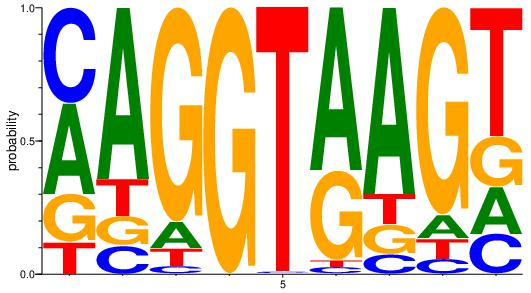

In [40]:
sl.seqlogo( ppm_sl, ic_scale = False, format = 'jpeg', size = 'medium')

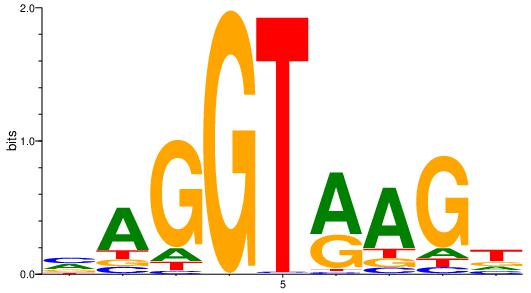

In [41]:
sl.seqlogo( ppm_sl, ic_scale = True, format = 'jpeg', size = 'medium')

In [42]:
chr11_seq = pp.get_refseq( fa_file_dir + 'chr11.fa' )[ 0 ]

In [43]:
css.rev_complement( chr11_seq[ 32413511:32413520 ] )

'CAAGTGCGT'